In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import scipy.signal as sig

In [2]:
output_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_double_support_code\test_hip_heel_dist'
csv_file_name = 'test_hip_heel_events.csv'
png_file_name = 'test_hip_heel_events.png'

mp_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_outputs_004\subset_for_memory_a\BW-0006\2022_09_26\000_raw_pose_data\gait_vertical_PWS_1_mediapipe.csv'
mp_world_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_outputs_004\subset_for_memory_a\BW-0006\2022_09_26\000_raw_pose_data\gait_vertical_PWS_1_mediapipe_world.csv'
yolo_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\gait_bw_zeno_outputs_004\subset_for_memory_a\BW-0006\2022_09_26\000_raw_pose_data\gait_vertical_PWS_1_yolo.csv'

In [3]:
# load datarames 
yolo_df = pd.read_csv(yolo_path, index_col = 0) 
mp_df = pd.read_csv(mp_path, index_col = 0)
mp_world_df = pd.read_csv(mp_world_path, index_col = 0)

In [4]:
# plot mediapipe Y right and left ankle 
mp_r_ank_df = mp_df.loc[mp_df['label'] == 'right_ankle']
mp_l_ank_df = mp_df.loc[mp_df['label'] == 'left_ankle']

smooth_r_y = mp_r_ank_df['Y']#.rolling(window=5, min_periods = 1).mean()
smooth_l_y = mp_l_ank_df['Y']#.rolling(window=5, min_periods = 1).mean()

mp_r_ank_df['neg_Y_smooth'] = -smooth_r_y
mp_l_ank_df['neg_Y_smooth'] = -smooth_l_y

C:\Users\mmccu\AppData\Local\Temp\ipykernel_29408\2714554401.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mp_r_ank_df['neg_Y_smooth'] = -smooth_r_y
C:\Users\mmccu\AppData\Local\Temp\ipykernel_29408\2714554401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mp_l_ank_df['neg_Y_smooth'] = -smooth_l_y


In [5]:
mp_r_ank_df.head()

,X,Y,Z,vis,pres,frame,label,neg_Y_smooth
28,0.154095,0.266982,0.000739,0.898375,0.0,35,right_ankle,-0.266982
28,0.149223,0.120819,-0.219706,0.846681,0.0,49,right_ankle,-0.120819
28,0.120130,0.129511,-0.164066,0.780410,0.0,50,right_ankle,-0.129511
28,0.117769,0.123230,-0.175364,0.710956,0.0,51,right_ankle,-0.123230
28,0.252757,-0.023782,0.272124,0.657669,0.0,89,right_ankle,0.023782


In [7]:
# identify where ankle y positions cross - toe off? 
def id_cross_frame(df):

    #  where right and left Y position cross = toe off 
    r_ankle_df = df.loc[df['label'] == 'right_ankle']
    r_ankle_df.set_index('frame', inplace=True)

    l_ankle_df = df.loc[df['label'] == 'left_ankle']
    l_ankle_df.set_index('frame', inplace=True)

    ankle_y_df = pd.DataFrame(data = {'r_ankle_neg_smooth_y' : -r_ankle_df['Y'], #.rolling(window=5, min_periods = 1).mean(), 
                                      'l_ankle_neg_smooth_y' : -l_ankle_df['Y']}#.rolling(window=5, min_periods = 1).mean()}
                             )
    ankle_y_df['r_l_neg_y_mean'] =  ankle_y_df[['r_ankle_neg_smooth_y', 
                                              'l_ankle_neg_smooth_y']].mean(axis=1)

    # Create a new column to identify whether col1 is greater than col2
    ankle_y_df['r_greater'] = ankle_y_df['r_ankle_neg_smooth_y'] > ankle_y_df['l_ankle_neg_smooth_y']

    # Find the places where the value of 'col1_greater' changes
    ankle_y_df['change'] = ankle_y_df['r_greater'].ne(ankle_y_df['r_greater'].shift())
    #print(ankle_y_df.head())

    # Get the frames where the change happens 
    y_cross_df = ankle_y_df.loc[ankle_y_df['change'] == True]

    return y_cross_df

In [8]:
# calculate difference between hip and heel 

def l_r_hip_heel_dist(df): 
    r_hip_df = df.loc[df['label'] == 'right_hip']
    r_hip_df.set_index('frame', inplace=True)

    l_hip_df = df.loc[df['label'] == 'left_hip']
    l_hip_df.set_index('frame', inplace=True)

    r_ankle_df = df.loc[df['label'] == 'right_ankle']
    r_ankle_df.set_index('frame', inplace=True)

    l_ankle_df = df.loc[df['label'] == 'left_ankle']
    l_ankle_df.set_index('frame', inplace=True)

    # try no smoothing - timing and order important and smoothing kind of shifts 
    # left dist  
    r_diff =  abs(r_ankle_df['Y'] - r_hip_df['Y'])#.rolling(window=5, min_periods = 1).mean()

    # right dist 
    l_diff = abs(l_ankle_df['Y'] - l_hip_df['Y'])#.rolling(window=5, min_periods = 1).mean()

    # diff df 
    diff_df = pd.DataFrame({'frame': l_ankle_df.index, 
                            'r_diff' : r_diff, 
                            'l_diff' : l_diff}) 

    # find peaks 
    r_peaks_i, _ = sig.find_peaks(diff_df['r_diff'], distance = 5)
    l_peaks_i, _ = sig.find_peaks(diff_df['l_diff'], distance = 5)

    # peak frames 
    r_peaks_df = pd.DataFrame(data = {'frame' : diff_df.iloc[r_peaks_i].index,
                                     'peak_val' : diff_df.iloc[r_peaks_i]['r_diff']}) 
    
    l_peaks_df = pd.DataFrame(data = {'frame' : diff_df.iloc[l_peaks_i].index, 
                                      'peak_val' : diff_df.iloc[l_peaks_i]['l_diff']})


    # find valleys 
    r_valley_i, _ = sig.find_peaks(-diff_df['r_diff'])#, distance = 5)
    l_valley_i, _ = sig.find_peaks(-diff_df['l_diff'])#, distance = 5)

    # peak frames 
    r_valley_df = pd.DataFrame(data = {'frame' : diff_df.iloc[r_valley_i].index,
                                     'valley_val' : diff_df.iloc[r_valley_i]['r_diff']}) 
    
    l_valley_df = pd.DataFrame(data = {'frame' : diff_df.iloc[l_valley_i].index, 
                                      'valley_val' : diff_df.iloc[l_valley_i]['l_diff']})

    

    return [diff_df, r_peaks_df, l_peaks_df, r_valley_df, l_valley_df]

In [9]:
# MP crossing frames 
mp_y_cross_df = id_cross_frame(mp_df)

mp_y_cross_df = mp_y_cross_df.reset_index()
mp_y_cross_df.head()

,frame,r_ankle_neg_smooth_y,l_ankle_neg_smooth_y,r_l_neg_y_mean,r_greater,change
0,35,-0.266982,-0.267693,-0.267338,True,True
1,51,-0.123230,-0.122162,-0.122696,False,True
2,89,0.023782,0.009243,0.016513,True,True
3,99,-0.002017,0.012359,0.005171,False,True
4,105,-0.054043,-0.058154,-0.056098,True,True


In [10]:
mp_y_r_greater_cross = mp_y_cross_df.loc[mp_y_cross_df['r_greater'] == True]
mp_y_l_greater_cross = mp_y_cross_df.loc[mp_y_cross_df['r_greater'] == False]

In [11]:
# mediapipe world diff between hip and heel = heel strike  
mp_diff_df, mp_r_peaks_df, mp_l_peaks_df, mp_r_valleys_df, mp_l_valleys_df = l_r_hip_heel_dist(mp_df) 

In [13]:
mp_diff_df

,frame,r_diff,l_diff
frame,,,
35,35,0.022646,0.017194
49,49,0.148877,0.134874
50,50,0.135275,0.132317
51,51,0.139150,0.135654
89,89,0.113619,0.108539
...,...,...,...
687,687,0.341134,0.331322
697,697,0.129214,0.149205
698,698,0.115318,0.093781


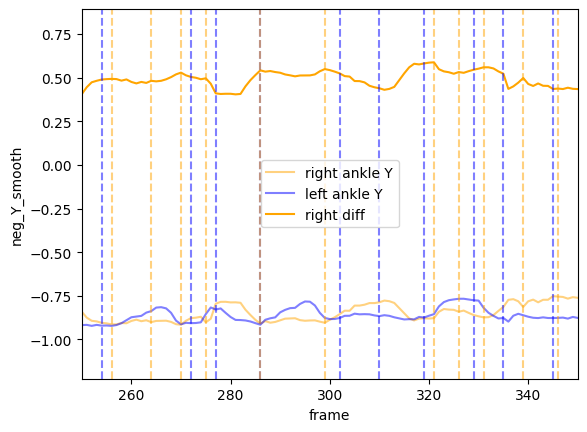

In [12]:
# plot r hip diff and r ankle Y on same pllot 
## Plot ankle y position 
sns.lineplot(x = 'frame', y = 'neg_Y_smooth', data = mp_r_ank_df, color = 'orange', label = 'right ankle Y', alpha = 0.5)
sns.lineplot(x = 'frame', y = 'neg_Y_smooth', data = mp_l_ank_df, color = 'blue', label = 'left ankle Y', alpha = 0.5)

## Plot hip and ankle y position diff 
sns.lineplot(x = 'frame', y = 'r_diff', data = mp_diff_df, color = 'orange', label = 'right diff', alpha = 1)

for frame in mp_r_peaks_df['frame']: 
    plt.axvline(frame, color = 'orange', linestyle = '--', alpha = 0.5)


for frame in mp_l_peaks_df['frame']: 
    plt.axvline(frame, color = 'blue', linestyle = '--', alpha = 0.5)
   
plt.xlim([250, 350])
plt.show()

In [14]:
mp_l_peaks_df

,frame,peak_val
frame,,
51,51,0.135654
98,98,0.167381
107,107,0.213138
122,122,0.334123
129,129,0.549129
139,139,0.522790
144,144,0.551329
151,151,0.510939
156,156,0.503979


In [ ]:
fig, axs = plt.subplots(2)

## Plot ankle y position 
sns.lineplot(x = 'frame', y = 'neg_Y_smooth', data = mp_r_ank_df, color = 'orange', label = 'right ankle Y', alpha = 0.5, ax = axs[0])
sns.lineplot(x = 'frame', y = 'neg_Y_smooth', data = mp_l_ank_df, color = 'blue', label = 'left ankle Y', alpha = 0.5, ax = axs[0])

# crossing of mediapipe Y ankle positions - toe off?
#for frame in mp_y_r_greater_cross['frame']: 
#    axs[1].axvline(frame, color = 'orange', linestyle = ':', alpha = 0.5)
#    axs[0].axvline(frame, color = 'orange', linestyle = ':', alpha = 0.5)

for frame in mp_y_l_greater_cross['frame']: 
    axs[1].axvline(frame, color = 'blue', linestyle = ':', alpha = 0.5)
    axs[0].axvline(frame, color = 'blue', linestyle = ':', alpha = 0.5)

## Plot hip and ankle y position diff 
sns.lineplot(x = 'frame', y = 'r_diff', data = mp_diff_df, color = 'orange', label = 'right diff', alpha = 0.5, ax = axs[1])
sns.lineplot(x = 'frame', y = 'l_diff', data = mp_diff_df, color = 'blue', label = 'left diff', alpha = 0.5, ax = axs[1])

# valley in hip ankle diff - heel strike? (idk, thought it would have been peaks (maybe issue with abs and neg hip to heel) 
#for frame in mp_r_peaks_df['frame']: 
#    axs[1].axvline(frame, color = 'orange', linestyle = '--', alpha = 0.5)
#    axs[0].axvline(frame, color = 'orange', linestyle = '--', alpha = 0.5)

for frame in mp_l_peaks_df['frame']: 
    axs[1].axvline(frame, color = 'blue', linestyle = '--', alpha = 0.5)
    axs[0].axvline(frame, color = 'blue', linestyle = '--', alpha = 0.5)

# add in cross frame of ankel y position and max value of hip to ankle diff 
axs[0].set_xlim([250, 350])
axs[1].set_xlim([250, 350])
plt.show()

# Old code 

In [ ]:
# yolo crossing frames 
yolo_y_cross_df = id_cross_frame(yolo_df)

sns.scatterplot(x = 'frame', y = 'r_l_neg_y_mean',  
                data = yolo_y_cross_df.loc[yolo_y_cross_df['r_greater'] == True],
                color = 'orange',
                label = 'right greater crosses ~ toe off')

sns.scatterplot(x = 'frame', y = 'r_l_neg_y_mean',  
                data = yolo_y_cross_df.loc[yolo_y_cross_df['r_greater'] == False],
                color = 'blue',
                label = 'left greater crosses ~ toe off')

plt.plot(yolo_df.loc[yolo_df['label'] == 'right_ankle']['frame'], 
         -yolo_df.loc[yolo_df['label'] == 'right_ankle']['Y'], 
         color = 'orange',
         label = 'right ankle Y', 
         alpha = 0.5)

plt.plot(yolo_df.loc[yolo_df['label'] == 'left_ankle']['frame'], 
         -yolo_df.loc[yolo_df['label'] == 'left_ankle']['Y'], 
         color = 'blue',
         label = 'left ankle Y', 
         alpha = 0.5)

#plt.xlim([300, 500])


In [ ]:
mp_r_peaks_df.head()

In [ ]:
# mediapipe world diff between hip and heel = heel strike  
sns.lineplot(x = 'frame', y = 'Y', data = mp_r_ank_df, color = 'orange', label = 'right ankle Y', alpha = 0.5)
sns.lineplot(x = 'frame', y = 'Y', data = mp_l_ank_df, color = 'blue', label = 'left ankle Y', alpha = 0.5)
plt.ylabel('MP Pose Right and Left Ankle Positions ')

for frame in mp_r_peaks_df['frame']: 
    print(frame)
    plt.axvline(frame, color = 'orange', linestyle = '--', alpha = 0.5)

for frame in mp_r_peaks_df['frame']: 
    plt.axvline(frame, color = 'blue', linestyle = '--', alpha = 0.5)

#plt.xlim([50, 200])
plt.legend()

In [ ]:
def id_gait_events_one_cycle(start_frame, all_toe_off_df, r_heel_strike_df, l_heel_strike_df, mp_df):

    # blank df for each event 
    gait_events_df = pd.DataFrame()

    # new df - only rows starting at start frame row 
    toe_off_start_df = all_toe_off_df.loc[all_toe_off_df.index >= start_frame]
    print(toe_off_start_df.head())
    
    # first toe off foot 1 
    foot1_to_1 = toe_off_start_df.index[0]
    print(foot1_to_1)
    foot_1_side = toe_off_start_df['r_greater'].iloc[0]
    print(foot_1_side)
    
    # second toe off foot 1 - next toe off with same foot 1 side 
    foot1_to_2_df = toe_off_start_df.loc[toe_off_start_df['r_greater'] == foot_1_side]
    print(foot1_to_2_df.head())

    print(foot1_to_2)

    # plot first to second toe off 
    sns.scatterplot(x = 'frame', y = 'r_l_neg_y_mean',  
                data = all_toe_off_df.loc[all_toe_off_df['r_greater'] == True],
                color = 'orange',
                label = 'right greater crosses ~ toe off')

    sns.scatterplot(x = 'frame', y = 'r_l_neg_y_mean',  
                data = all_toe_off_df.loc[all_toe_off_df['r_greater'] == False],
                color = 'blue',
                label = 'left greater crosses ~ toe off')

    plt.plot(mp_df.loc[mp_df['label'] == 'right_ankle']['frame'], 
             -mp_df.loc[mp_df['label'] == 'right_ankle']['Y'], 
             color = 'orange',
             label = 'right ankle Y')

    plt.plot(mp_df.loc[mp_df['label'] == 'left_ankle']['frame'], 
            -mp_df.loc[mp_df['label'] == 'left_ankle']['Y'], 
             color = 'blue',
             label = 'left ankle Y')
    plt.xlim([foot1_to_1, ])

    # is there a toe off of foot two between both foot 1 toe offs?
        # if no --> blank data frame --> don't calc 
        # if yes --> foot 2 first toe off



    

    

    
id_gait_events_one_cycle(start_frame = 2, 
                             all_toe_off_df = mp_y_cross_df, 
                             r_heel_strike_df = mp_r_peaks_df, 
                             l_heel_strike_df = mp_l_peaks_df, 
                            mp_df= mp_df)


In [ ]:
for toe_off_frame_i, toe_off_frame in enumerate(mp_y_cross_df['frame']): 
    id_gait_events_one_cycle(start_frame = toe_off_frame, 
                             all_toe_off_df = mp_y_cross_df, 
                             r_heel_strike_df = mp_r_peaks_df, 
                             l_heel_strike_df = mp_l_peaks_df)

In [ ]:

def calculate_metrics_per_cycle()

In [ ]:
# function - start at heel strike? or toe off? and id gait events 
# state estimator 
    # toe off to toe off --> find (first? max?) heel strike (max hip heel dist) between the two toe offs; max if multiple 



# left stats 
left_stats = []
right_stats = []

# loop start - loop through each frame of mp_y_cross_df (toe off) 

    # blank dataframe  - gait cycle (toe off 1, heel strike 1, toe off 2 etc) 

    # new - function fill in blank data frame with each gait cycle event  
         # if not able to

    # new function - if step above is not nan, calculate double single support, stance/swing, etc 
       

    # ifmp_y_cross_df r_greater == Tru append to righ tstats, append to lef tstats if false 

# mean/median 